# Electromagnetic 3d waveguide


### by M. Wess, 2024
*This Notebook is part of the `dualcellspaces` [documentation](https://ngsolve.github.io/dcm) for the addon package implementing the Dual Cell method in [NGSolve](https://ngsolve.org).*

In [1]:
#import libraries

from ngsolve import *
# import netgen.gui
import dualcellspaces as dcs
from ngsolve.webgui import Draw

import numpy as np
import matplotlib.pyplot as pl

In [2]:
#set parameters

omega = 10

lx = 1
ly = 1
lz = 4

#radius of obstacle
rad = 0.3

maxh = 0.2
order = 2

#experimentally stable timestep
tau = 0.08*maxh/(order+1)**2 

c=5
t0=1       

In [3]:
from netgen.occ import *
wg = Box(Pnt(0,0,0),Pnt(lx,ly,lz))
wg.faces.Min(Z).name = 'inflow'

sphere = Sphere(Pnt(lx/2,ly/2,lz/2),rad)

geo = OCCGeometry(wg-sphere)

mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)
Draw(mesh, clipping={"y":1, "z":0}, euler_angles=[-120,2,-15])


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': [-…

BaseWebGuiScene

In [4]:
fes_E = dcs.HCurlDualCells3D(mesh, order=order,dirichlet = mesh.Boundaries('.*'))
fes_H = dcs.HCurlPrimalCells3D(mesh,order=order)

fes = fes_E*fes_H
print("total DoFs:",fes.ndof)
gf = GridFunction(fes)
gfE, gfH = gf.components


#integral symbols with special integration rules
dxE = dx(intrules=fes_E.GetIntegrationRules())
dsE = ds(intrules=fes_E.GetIntegrationRules(),definedon=mesh.Boundaries('inflow'))
dxH = dx(intrules=fes_H.GetIntegrationRules())

dxw = dx(intrules=dcs.GetIntegrationRules(2*order+4))
dSw = dx(element_boundary=True,intrules=dcs.GetIntegrationRules(2*order+4))


#mixed bilinear form
E,dE = fes_E.TnT()
H,dH = fes_H.TnT()

normal = specialcf.normal(3)
bf_mixed = BilinearForm(E*curl(dH)*dxw+E*Cross(dH,normal)*dSw, geom_free=True).Assemble().mat

total DoFs: 1280304


In [5]:
#prepare mass operators
with TaskManager():
    massH_inv = fes_H.Mass(1).Inverse()
    bfm_E = fes_E.Mass(1)
    massE_inv = bfm_E.Inverse(freedofs=fes_E.FreeDofs())
    massE_surf = BilinearForm(E.Trace()*dE.Trace()*dsE).Assemble().mat#
    massE_surf = massE_surf.DeleteZeroElements(1e-8)
    massE_surf_inv = massE_surf.Inverse(inverse='sparsecholesky',freedofs=fes_E.GetDofs(mesh.Boundaries('inflow')))

used dof inconsistency
(silence this warning by setting BilinearForm(...check_unused=False) )


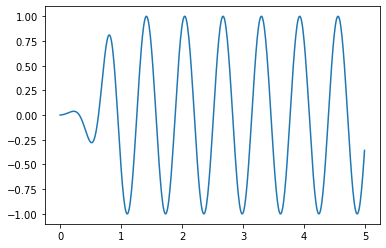

In [6]:
#dirichlet data
plx = pi/lx
gfe=GridFunction(fes_E)


lfr = LinearForm(InnerProduct(CF((0,sin(x*plx),0)),dE.Trace())*dsE).Assemble().vec
gfe.vec.data = massE_surf_inv*lfr
#Draw(gfe)

        
rhsEfunc = lambda t: exp(-c*(t<t0)*(t0-t)**2)*sin(omega*t)*gfe.vec

#visualize dirichlet data over time
ts = np.arange(0,5,0.01)
pl.plot(ts,np.exp(-c*(ts<t0)*(t0-ts)**2)*np.sin(omega*ts))
pl.show()


In [7]:
#Draw solution
#scenee = Draw (gfE[1], mesh, "E", order=2, draw_surf=False, clipping={"y":1, "z":0},min=-0.5,max=0.5,autoscale=False,points=dcs.GetWebGuiPoints(2),settings = {"Objects" : {"Clipping Plane" : True}}, euler_angles=[-120,2,-15])
#sceneh = Draw (gfH.Operator("altshape")[2], mesh, "H", order=2, draw_surf=False, clipping={"y":1, "z":0},min=-0.5,max=0.5,autoscale=False)
gfE_anim = GridFunction(fes_E,multidim=0)

In [8]:
from time import time

drawevery = 100
tend = 4

t = 0.
i = 0

gfH.vec[:]=0
gfE.vec[:]=0

tmpE = gfE.vec.CreateVector()

now = time()
timepassed = 0
with TaskManager():
    gfH.vec.data += -tau/2*massH_inv@bf_mixed*gfE.vec
    while t<tend:
        
        t+=tau       
        i+=1
        tmpE.data = tau*bf_mixed.T*gfH.vec+bfm_E*(gfE.vec-rhsEfunc(t))
        gfE.vec.data = rhsEfunc(t)
        gfE.vec.data += massE_inv*tmpE
        
        gfH.vec.data += -tau*massH_inv@bf_mixed*gfE.vec
        if i%drawevery == 0:
            timepassed += time()-now
            #scenee.Redraw()
            #sceneh.Redraw()
            gfE_anim.AddMultiDimComponent(gfE.vec)
            #print("\r time = {}, step = {},  {:e} dofs/s".format(t,i,drawevery*fes.ndof/timepassed),end="")
            now = time()



In [9]:
print("finshed with an average of {:e} dofs/s".format(i*fes.ndof/timepassed),end="")
Draw (gfE_anim, mesh, order=2, animate = True, draw_surf=False, clipping={"y":1, "z":0},min=-0.5,max=0.5,autoscale=False,points=dcs.GetWebGuiPoints(2),settings = {"eval": 1, "Objects" : {"Clipping Plane" : True}}, euler_angles=[-120,2,-15]);

finshed with an average of 9.010176e+07 dofs/s

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'eval': 1, 'Objects': {'Clipp…